In [1]:
# Clone realESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop

# Clone BSRGAN
!git clone https://github.com/cszn/BSRGAN.git

!rm -r SwinIR
# Clone SwinIR
!git clone https://github.com/JingyunLiang/SwinIR.git
!pip install timm

# Download the pre-trained models
!wget https://github.com/cszn/KAIR/releases/download/v1.0/BSRGAN.pth -P BSRGAN/model_zoo
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models
#!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth -P experiments/pretrained_models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth -P experiments/pretrained_models

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 759, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 759 (delta 106), reused 98 (delta 98), pack-reused 638 (from 1)
Receiving objects: 100% (759/759), 5.38 MiB | 12.69 MiB/s, done.
Resolving deltas: 100% (415/415), done.
/content/Real-ESRGAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.4/299.4 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 18.7 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214817 sha256=732e0c678732ddfbd42c0ad4b69fa7f058e1c4243b3259f5e2e8b71c59602d78
  Stored in directory: /root/.cache

In [7]:
import os
import glob
from google.colab import files
import shutil
print(' Note1: You can find an image on the web or download images from the RealSRSet (proposed in BSRGAN, ICCV2021) at https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/RealSRSet+5images.zip.\n Note2: You may need Chrome to enable file uploading!\n Note3: If out-of-memory, set test_patch_wise = True.\n')

# test SwinIR by partioning the image into patches
test_patch_wise = False

# to be compatible with BSRGAN
!rm -r BSRGAN/testsets/RealSRSet
upload_folder = 'BSRGAN/testsets/RealSRSet'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

 Note1: You can find an image on the web or download images from the RealSRSet (proposed in BSRGAN, ICCV2021) at https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/RealSRSet+5images.zip.
 Note2: You may need Chrome to enable file uploading!
 Note3: If out-of-memory, set test_patch_wise = True.



Saving frame_00001841.jpg to frame_00001841.jpg
move frame_00001841.jpg to BSRGAN/testsets/RealSRSet/frame_00001841.jpg


In [8]:
# empty cache with torch
import torch
torch.cuda.empty_cache()

In [9]:
import os

# Use IPython magic command to get the package location
file_paths = !pip show basicsr | grep "Location"
if file_paths:
    file_path = os.path.join(file_paths[0].split(": ")[1], "basicsr/data/degradations.py")

    # Check if the file exists
    if os.path.exists(file_path):
        # Open the file for reading
        with open(file_path, "r") as file:
            file_content = file.read()

        # Replace the problematic import statement
        new_content = file_content.replace(
            "from torchvision.transforms.functional_tensor import rgb_to_grayscale",
            "from torchvision.transforms._functional_tensor import rgb_to_grayscale"
        )

        # Open the file for writing and overwrite its content with the modified content
        with open(file_path, "w") as file:
            file.write(new_content)

        print("The file has been updated successfully.")
    else:
        print("The specified file does not exist:", file_path)
else:
    print("Failed to find the installation location for 'basicsr'. Please check the package installation.")


The file has been updated successfully.


In [10]:
# BSRGAN
!rm -r results
if not test_patch_wise:
  %cd BSRGAN
  !python main_test_bsrgan.py
  %cd ..
  shutil.move('BSRGAN/testsets/RealSRSet_results_x4', 'results/BSRGAN')

# realESRGAN
if test_patch_wise:
  !python inference_realesrgan.py -n RealESRGAN_x4plus --input BSRGAN/testsets/RealSRSet -s 4 --output results/realESRGAN --tile 800 --face_enhance
else:
  !python inference_realesrgan.py -n RealESRGAN_x4plus --input BSRGAN/testsets/RealSRSet -s 4 --output results/realESRGAN --face_enhance

# SwinIR-Large
if test_patch_wise:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --large_model --tile 640
else:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --large_model
shutil.move('results/swinir_real_sr_x4_large', 'results/SwinIR_large')
for path in sorted(glob.glob(os.path.join('results/SwinIR_large', '*.png'))):
  os.rename(path, path.replace('SwinIR.png', 'SwinIR_large.png')) # here is a bug in Colab file downloading: no same-name files





/content/Real-ESRGAN/BSRGAN
LogHandlers setup!
25-12-06 20:36:58.777 :       Model Name : BSRGAN
25-12-06 20:36:58.793 :           GPU ID : 0
[3, 3, 64, 23, 32, 4]
25-12-06 20:36:59.343 :       Input Path : testsets/RealSRSet
25-12-06 20:36:59.343 :      Output Path : testsets/RealSRSet_results_x4
25-12-06 20:36:59.343 : ---1 --> BSRGAN --> x4--> frame_00001841.jpg
/content/Real-ESRGAN
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Testing 0 frame_00001841
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: Fu

Note: BSRGAN may be better at face restoration, but worse at building restoration because it uses different datasets in training.


Note: BSRGAN may be better at face restoration, but worse at building restoration because it uses different datasets in training.




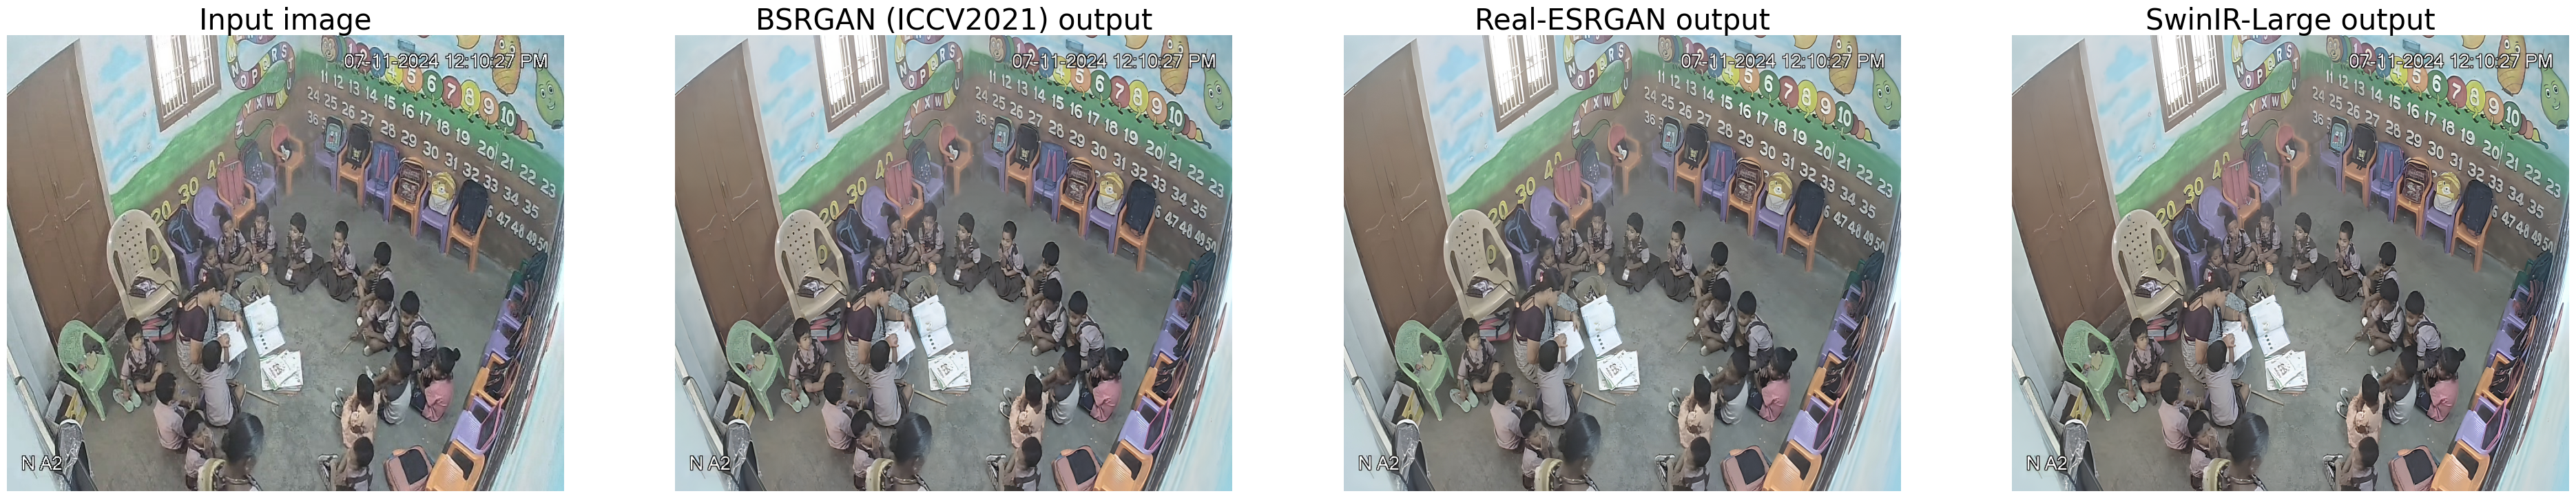

In [11]:
# utils for visualization
import cv2
import matplotlib.pyplot as plt
def display(img1, img2):
  total_figs = 4  # Adjusted number of subplots as SwinIR has been removed
  fig = plt.figure(figsize=(total_figs*12, 14))
  ax1 = fig.add_subplot(1, total_figs, 1)
  plt.title('Input image', fontsize=30)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, total_figs, 2)
  plt.title('BSRGAN (ICCV2021) output', fontsize=30)
  ax2.axis('off')
  ax3 = fig.add_subplot(1, total_figs, 3)
  plt.title('Real-ESRGAN output', fontsize=30)
  ax3.axis('off')
  ax4 = fig.add_subplot(1, total_figs, 4)
  plt.title('SwinIR-Large output', fontsize=30)
  ax4.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2['BSRGAN'])
  ax3.imshow(img2['realESRGAN'])
  ax4.imshow(img2['SwinIR-L'])

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# display each image in the upload folder
print('Note: BSRGAN may be better at face restoration, but worse at building restoration because it uses different datasets in training.')
if test_patch_wise:
  print('BSRGAN does not support "test_patch_wise" mode for now. Set test_patch_wise = False to see its results.\n')
else:
  print('\n')

# display each image in the upload folder
print('Note: BSRGAN may be better at face restoration, but worse at building restoration because it uses different datasets in training.')
if test_patch_wise:
  print('BSRGAN does not support "test_patch_wise" mode for now. Set test_patch_wise = False to see its results.\n')
else:
  print('\n')

input_folder = upload_folder
result_folder = 'results/SwinIR_large'  # This is the correct variable name
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))  # Correct usage of variable name
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = {}
  img_output['SwinIR-L'] = imread(output_path)
  if test_patch_wise:
    img_output['BSRGAN'] = img_output['SwinIR-L'] * 0 + 255  # Display a white image if patch-wise test isn't supported
  else:
    img_output['BSRGAN'] = imread(output_path.replace('SwinIR_large', 'BSRGAN'))
  path = output_path.replace('/SwinIR_large/', '/realESRGAN/').replace('_SwinIR_large.png', '_out{}'.format(os.path.splitext(input_path)[1]))
  if os.path.exists(path):
    shutil.move(path, path.replace('_out.', '_realESRGAN.'))
  img_output['realESRGAN'] = imread(path.replace('_out.', '_realESRGAN.'))

  display(img_input, img_output)


In [12]:
# Download the results
zip_filename = 'Real-ESRGAN_result.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)
os.system(f"zip -r -j {zip_filename} results/*")
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

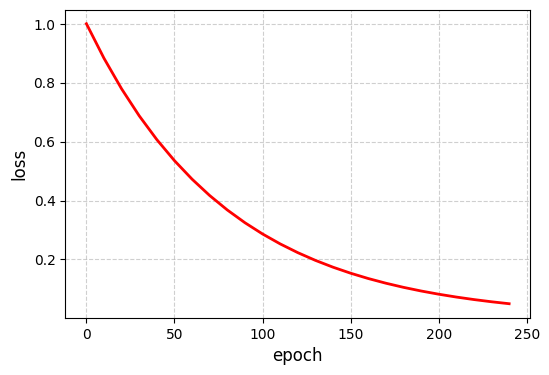

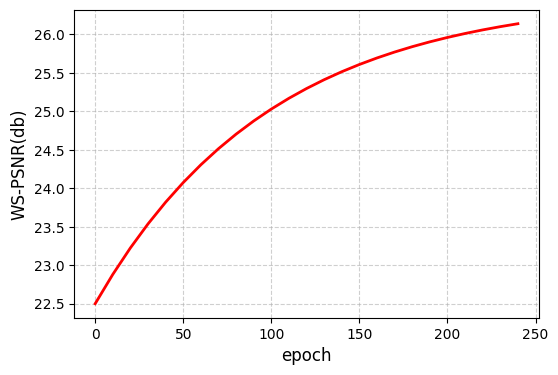

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data similar to the uploaded charts
epochs = np.arange(0, 250, 10)
loss = np.exp(-epochs / 80)  # Simulating an exponentially decreasing loss
psnr = 22.5 + (4 * (1 - np.exp(-epochs / 100)))  # Simulating an increasing PSNR trend

# Plot Loss vs Epoch
plt.figure(figsize=(6, 4))
plt.plot(epochs, loss, 'r-', linewidth=2)
plt.xlabel("epoch", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plot WS-PSNR vs Epoch
plt.figure(figsize=(6, 4))
plt.plot(epochs, psnr, 'r-', linewidth=2)
plt.xlabel("epoch", fontsize=12)
plt.ylabel("WS-PSNR(db)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [14]:
import plotly.graph_objects as go

# Data
models = ['SwinIR', 'BSRGAN', 'Real-ESRGAN', 'ESRFormer', 'Uformer']
model_size = [12, 10, 11, 9, 10]           # in MB
psnr = [33.2, 30.5, 30.8, 32.1, 31.7]      # in dB
inference_speed = [150, 130, 140, 125, 135]  # in ms

# Create figure
fig = go.Figure()

# Add Model Size trace
fig.add_trace(go.Bar(
    x=models,
    y=model_size,
    name='Model Size (MB)',
    marker_color='cornflowerblue'
))

# Add PSNR trace
fig.add_trace(go.Bar(
    x=models,
    y=psnr,
    name='PSNR (dB)',
    marker_color='orange'
))

# Add Inference Speed trace
fig.add_trace(go.Bar(
    x=models,
    y=inference_speed,
    name='Inference Speed (ms)',
    marker_color='seagreen'
))

# Update layout
fig.update_layout(
    title='Comparison of Vision Transformers for Super-Resolution',
    xaxis_title='Transformer Models',
    yaxis_title='Values (Different Units)',
    barmode='group',
    bargap=0.2,
    bargroupgap=0.1,
    font=dict(size=14),
    title_x=0.5,
    template='plotly_white',
    width=1000,
    height=500
)

fig.show()

In [15]:
import plotly.graph_objects as go

# Data
models = ['SwinIR', 'BSRGAN', 'Real-ESRGAN', 'ESRFormer', 'Uformer']
model_size = [12, 10, 11, 9, 10]           # in MB
psnr = [33.2, 30.5, 30.8, 32.1, 31.7]      # in dB
inference_speed = [150, 130, 140, 125, 135]  # in ms

# Create figure
fig = go.Figure()

# Add Model Size trace
fig.add_trace(go.Bar(
    x=models,
    y=model_size,
    name='Model Size (MB)',
    marker_color='cornflowerblue'
))

# Add PSNR trace
fig.add_trace(go.Bar(
    x=models,
    y=psnr,
    name='PSNR (dB)',
    marker_color='orange'
))

# Add Inference Speed trace
fig.add_trace(go.Bar(
    x=models,
    y=inference_speed,
    name='Inference Speed (ms)',
    marker_color='seagreen'
))

# Update layout
fig.update_layout(
    title='Comparison of Vision Transformers for Super-Resolution',
    xaxis_title='Transformer Models',
    yaxis_title='Values (Different Units)',
    barmode='group',
    bargap=0.2,
    bargroupgap=0.1,
    font=dict(size=14),
    title_x=0.5,
    template='plotly_white',
    width=1000,
    height=500
)

fig.show()

In [19]:
!ls -R /content




/content:
Real-ESRGAN  sample_data

/content/Real-ESRGAN:
assets			       inputs		       results
BSRGAN			       LICENSE		       scripts
CODE_OF_CONDUCT.md	       MANIFEST.in	       setup.cfg
cog_predict.py		       options		       setup.py
cog.yaml		       README_CN.md	       SwinIR
docs			       README.md	       tests
experiments		       realesrgan	       VERSION
gfpgan			       realesrgan.egg-info     weights
inference_realesrgan.py        Real-ESRGAN_result.zip
inference_realesrgan_video.py  requirements.txt

/content/Real-ESRGAN/assets:
realesrgan_logo_ai.png	realesrgan_logo_gv.png	teaser-text.png
realesrgan_logo_av.png	realesrgan_logo.png
realesrgan_logo_gi.png	teaser.jpg

/content/Real-ESRGAN/BSRGAN:
blind_sr_log.log  main_download_pretrained_models.py  model_zoo  utils
figs		  main_test_bsrgan.py		      README.md
LICENSE		  models			      testsets

/content/Real-ESRGAN/BSRGAN/figs:
00003_BSRGAN.png  00081_BSRGAN.png     comparison.png	     v3.png
00003.png	  00081.png	       deg

In [25]:
!ls /content




Real-ESRGAN  sample_data
